# 第4回 OpenAI API, Gemini API - 演習

## 準備 1 - 演習資料のダウンロード

今回の演習で使用するファイルを各自のドライブにコピーする
1. Google Colabを開く
1. [ファイル] > [ノートブックを開く] を選択する
1. [GitHub] を選択して、“HarmoLab/aitr”と入力する
1. “2025/exercise_04/OpenAI_API_演習.ipynb”を選択する
1. [ドライブにコピー] を選択する（保存場所: “マイドライブ/Colab Notebooks”）

## 準備 2 - 必要なライブラリのインストールと読み込み

In [ ]:
!pip install -q openai==2.3.0
!pip install -q datasets==3.6.0

In [ ]:
from google.colab import userdata # シークレットに保存している値を読み込むため
from openai import OpenAI         # OpenAI APIを使用するため
from google import genai          # Gemini APIを使用するため
import datasets                   # 今回使用するデータセットを読み込むため

## 準備 3 - APIキーの設定

以下の手順によって、OpenAI APIのAPIキーを環境変数に登録する。

1. 左側のツールバーから`シークレット`（鍵のアイコン）を選択する。
1. 目のアイコンを押して、値が表示されている状態にする。
1. APIキーを入力する。

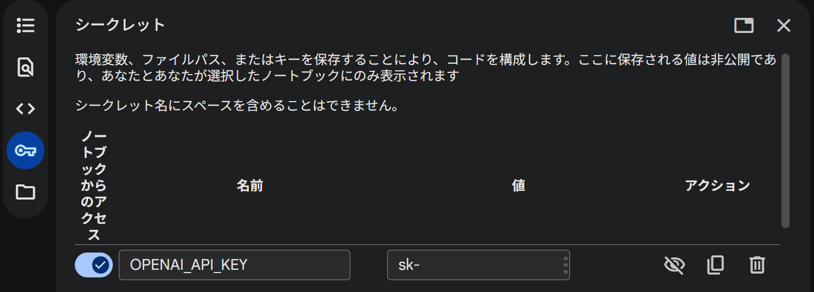

### 動作確認

以下のコードを実行して、APIキーが正しく登録できていることを確認します。<br>
正しく動作できていれば、適切な返答の文章が出力されます。

In [ ]:
client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
response = client.responses.create(model="gpt-5-mini", input="こんにちは")
print(f"OpenAI APIのレスポンス: {response.output_text}")

`userdata.get("<取得したいシークレット名>")`の部分で、シークレットに保存している値を呼び出している。

## 練習問題 1 - シンプルな文章生成タスク

文章を生成するためには、`responses.create()`メソッドを使用する。<br>
主な引数を以下に示す。

| 引数 | 取りうる値 | 説明 |
| - | - | - |
| `model` | 文字列 | 使用するモデルを指定する |
| `instructions` | 文字列 | AIの応答のスタイル、トーン、役割などを設定する指示文章（任意） |
| `input` | 文字列または配列 | システムに対しての指示文章や今までの会話履歴 |
| `temperature` | 0 ~ 2の数値 | AIが生成する文章のランダム性や創造性を調整するパラメータ（0に近いほど出力のランダム性が低くなる）（任意） |
| `max_output_tokens` | 整数 | 出力トークン数の上限（任意） |

（さらに詳しい引数の情報を知りたい方は、[公式リファレンス - Create a model response](https://platform.openai.com/docs/api-reference/responses/create)を参照する。）

ここでは、`input`として与える`user_prompt`を変更して、AIの出力が変わるところを観察する。

In [ ]:
model = "gpt-5-mini"
# ここを修正 #############################################
user_prompt = "ChatGPTについて簡潔に3文で教えてください。"

# user_prompt = """\
# ChatGPTについて簡潔に3文で教えてください。
# 出力は番号付きの箇条書きにしてください。
# """
#########################################################

client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
response = client.responses.create(model=model, input=user_prompt)

print(f"--- 質問 ---\n{user_prompt}")
print(f"--- 回答 ---\n{response.output_text}")

[公式ドキュメント - Text generation](https://platform.openai.com/docs/guides/text-generation)に簡単な使用例が記載されているので、参考にすると良い。<br>


## 練習問題 2 - オープンデータセットを用いた文章分類

今回は、Amazonの商品レビューの文章とその評価値のデータセットである、[`mteb/amazon_reviews_multi`](https://huggingface.co/datasets/mteb/amazon_reviews_multi/viewer/ja)を使用する。<br>
初めにデータセットを正しく読み込むことができるかを確認する。<br>
以下のコードを実行して、レビューの文章が出力できていれば成功である。

In [ ]:
dataset = datasets.load_dataset("mteb/amazon_reviews_multi", "ja", split="validation")
print(dataset[0]["text"])

次に、レビュー文の評価をするためのコードを実行して、正しく出力されることを確認する。<br>
以下のコードを実行して、レビュー文に対する評価をしている文章が出力できていれば成功である。

In [ ]:
model = "gpt-5-mini"
system_prompt = "以下のレビュー文を評価してください。"
user_prompt = dataset[0]["text"]  # レビュー文のみを`user_prompt`に格納

client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
response = client.responses.create(model=model, instructions=system_prompt, input=user_prompt)
print(response.output_text)

## 演習問題 1 - 実際の評価値に近づけるための質問方法

In [ ]:
# この部分のコードは、短時間に大量のリクエストを送ることを回避するためのコードです。
# この演習問題の趣旨とは関係がないので、コード自体を気にする必要はありませんが、このセルは必ず実行してください。

from tenacity import retry, stop_after_attempt, wait_random_exponential

# forでループするために関数化 (RateLimit対策のためtenacityのデコーダを採用)
# 参考: https://cookbook.openai.com/examples/how_to_handle_rate_limits
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def openai_run(client: OpenAI, model: str, system_prompt: str, user_prompt: str):
    response = client.responses.create(
        model=model,
        instructions=system_prompt,
        input=user_prompt,
        temperature=0.0,
        timeout=15,
    )
    return response

In [ ]:
model_name = "gpt-5-mini"
k = 10  # k件のレビュー文に対する評価
seed = 70 # データセットをシャッフル方法を固定するための変数
shuffled_dataset = dataset.shuffle(seed=seed)
review_list = shuffled_dataset[:k]["text"]
label_list = shuffled_dataset[:k]["label"]

# 演習問題1: 正答率と評価値を上げるためのsystem_promptを考える。 ###############
system_prompt = """\
以下のレビュー文を5段階評価してください。
"""
################################################################################
client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))

predict_label_list = []
for i, (review, label) in enumerate(zip(review_list, label_list)):
    response = openai_run(client, model_name, system_prompt, review)

    print(f"\n********** {i + 1}件目のレビュー **********")
    print(f"--- レビュー文 ---\n{review}")
    print(f"--- 実際の評価 ---\n{label}")
    print("--- 回答 ---")
    print(response.output_text)

    try:
        predict_label = int(response.output_text)
        predict_label_list.append(predict_label)
    except ValueError:
        print("--- Error ---")
        print(f"回答がint型に変換できませんでした。")
        predict_label_list.append(-1)
        continue

In [ ]:
# 評価
# 実際の評価と予測した評価の差の合計を評価値 (loss)
# 予測した評価が-1（出力形式のエラー）の場合は+6
validation_score = 0  # 評価値
correct_answer = 0    # 正解数
for actual, predict in zip(label_list, predict_label_list):
    validation_score += 6 if predict == -1 else abs(actual - predict)
    correct_answer += 1 if actual == predict else 0

print(f"実際の評価: {label_list}")
print(f"予測の評価: {predict_label_list}")
print(f"正答率: {correct_answer / len(label_list) * 100} %")
print(f"評価値: {validation_score} （低いほうが良い結果）")

## 演習問題 2 - 旅行プランの提案

以下のような旅行プランを出力するような対話アプリを作成したいと考えている。

```
## 札幌の魅力に酔いしれる旅 2泊3日

## スケジュール表

|日程|予定|
|----|----|
|1日目|札幌の歴史と美食を堪能|
|2日目|自然とアートを楽しむ|
|3日目|観光名所を巡るお散歩|

## 具体的なスケジュール

### 1日目
初日は札幌の歴史と美食を心ゆくまで楽しみましょう。
- 朝食：札幌駅周辺で朝食を食べる
- 10:00 - 12:00：札幌市時計台を訪れる。歴史的な建物や時計台内部の展示を見学し、札幌の歴史に触れましょう。
- 昼食：すすきの周辺で、札幌ラーメンやジンギスカンを堪能しましょう。
- 14:00 - 17:00：札幌市内を散策し、狸小路や大通公園に足を運びましょう。ショッピングやストリートパフォーマンスを楽しむこともできます。
- 夕食：すすきの周辺で、海鮮料理や居酒屋を味わいましょう。
- 夜の楽しみ：ライトアップされた大通公園や夜景スポットで、札幌の美しい夜景を満喫しましょう。

### 2日目
自然とアートを楽しむ2日目です。札幌の魅力に酔いしれましょう。
- 朝食：札幌駅周辺で朝食を食べる
- 9:00 - 12:00：円山動物園へ訪れ、可愛らしい動物たちとふれあいましょう。
- 昼食：円山公園内でピクニックランチを楽しむ
- 13:30 - 16:30：北海道立近代美術館へ行き、美術作品に酔いしれましょう。現代アートの展示や特別展示を堪能することができます。
- 夕食：すすきの周辺で、新鮮な海産物が楽しめる居酒屋を探してみましょう。
- 夜の楽しみ：札幌市内のパブやバーで、地元の人々と交流しながら夜を楽しみましょう。

### 3日目
最終日は観光名所を巡るお散歩を楽しみましょう。
- 朝食：札幌駅周辺で朝食を食べる
- 9:00 - 11:00：北海道神宮で朝の祈りを捧げましょう。美しい神社内部や庭園を散策することもできます。
- 昼食：大通公園周辺のカフェやレストランで、旅の思い出を振り返りながらランチをしましょう。
- 12:30 - 15:30：白い恋人パークに行き、チョコレート工場見学や工場直売所でお土産を買いましょう。
- 16:00 - 18:00：札幌テレビ塔に登り、絶景を楽しみましょう。札幌の景色を一望することができます。
- 夕食：すすきの周辺で、お気に入りのレストランで最後の晩餐を楽しみましょう。

札幌の魅力が詰まった2泊3日の旅行プランです。思い出に残る素敵な時間をお過ごしください！
```

`system_prompt`に記載する内容として、どのようなものにすべきかを考えましょう。<br>
ただし、`user_prompt`は変更しないことにする。

In [ ]:
model = "gpt-5-mini"
# 演習問題2: 目的の出力を得るためのsystem_promptを考える #######################
system_prompt = """\
ユーザの質問に回答してください。
"""
################################################################################
user_prompt = "2泊3日の札幌観光旅行のプランを考えてください。"  # 変更しない

client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
response = client.responses.create(
    model=model,
    instructions=system_prompt,
    input=user_prompt,
)
print(response.output_text)
print(f"--- システムプロンプト ---\n{user_prompt}\n")
print(f"---------- 回答 ----------\n{response.text}")

## 参考情報 1 - Gemini APIの基礎的な使い方

ここでは、Gemini APIを使用して、簡単な文章生成タスクを実行することを考える。<br>
基本的にOpenAI APIのときと同じように、AIを利用することができる。<br>
主に異なる点は、メソッドや引数の指定方法である。<br>
以下にOpenAI APIとGemini APIのコードを記載するので、違いを観察すると良い。

In [ ]:
# OpenAI API, Gemini API 共通 ###############################
system_prompt = "子供にも伝わるような話し方にしてください。"
user_prompt = "ChatGPTについて簡潔に3文で教えてください。"
#############################################################

# OpenAI API ################################################
client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
response = client.responses.create(
    model="gpt-5-mini",
    instructions=system_prompt,
    input=user_prompt,
)
print("========== OpenAI API ==========")
print(f"--- 質問 ---\n{user_prompt}")
print(f"--- 回答 ---\n{response.output_text}")
print("================================\n")
#############################################################

# Gemini API ################################################
client = genai.Client(api_key=userdata.get("GEMINI_API_KEY"))
response = client.models.generate_content(
    model="gemini-2.5-flash-lite",
    config=genai.types.GenerateContentConfig(
        system_instruction=system_prompt,
    ),
    contents=user_prompt,
)
print("========== Gemini API ==========")
print(f"--- 質問 ---\n{user_prompt}")
print(f"--- 回答 ---\n{response.text}")
print("================================")
#############################################################

さらに詳しい使い方を知りたい方は、[公式リファレンス - テキスト生成](https://ai.google.dev/gemini-api/docs/text-generation?hl=ja)を参照する。

## 参考情報 2 - 料金の計算

APIを使用したコードを実行したときに、どの程度の金額を使用したのかを知る方法はいくつかある。<br>
確実な方法として、APIサービスを提供しているプラットフォームのAPI管理画面から確認する方法がある。<br>
以下にOpenAI APIの使用状況の確認画面を示す。
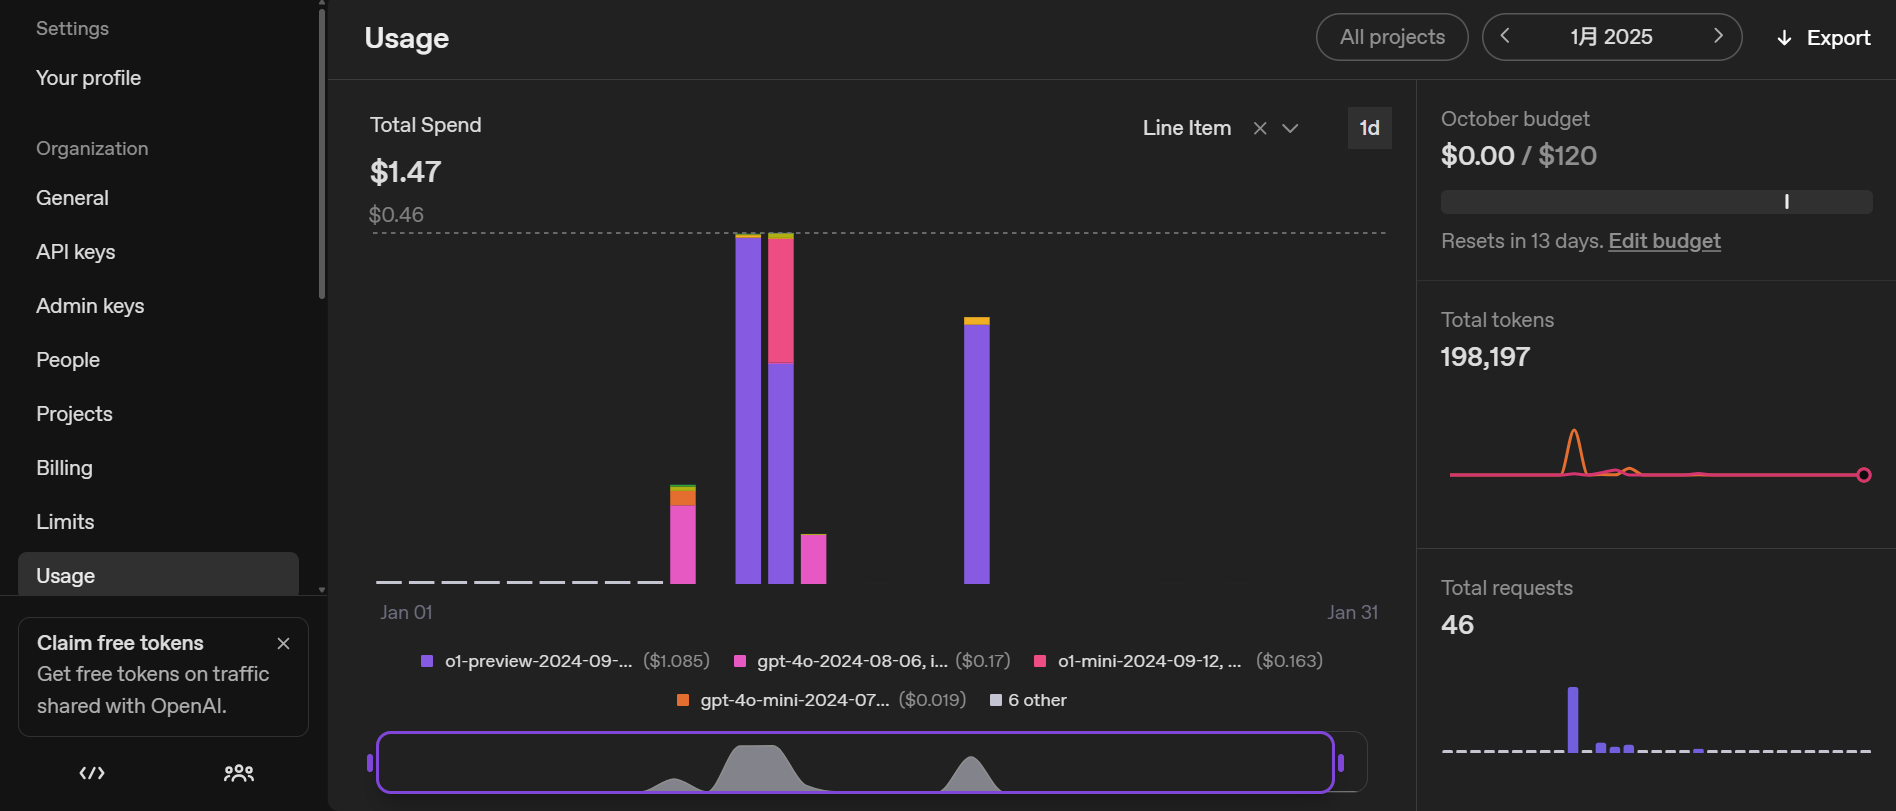

しかし、管理画面を確認できない場合や、実行するごとにどの程度の金額をその場で確認したい場合もある。<br>
そのような場合には、レスポンスに含まれるトークン数などの情報から金額を計算するメソッドがあると便利である。<br>
ここでは、OpenAI APIとGemini APIに対する料金計算のメソッドを以下に示す。<br>
今後、APIを使用するときに料金が把握できるので、適宜活用すると良い。

In [ ]:
# OpenAI API - 料金計算メソッド
from openai.types.responses.response import Response

def calculate_credit_openai(response: Response) -> float:
  model = response.model
  if model == "gpt-5-mini-2025-08-07": # 日付はモデルの更新によって変わる可能性があるので注意
    input_token_unit_price = 0.25 / 1000000
    output_token_unit_price = 2.00 / 1000000
  elif model == "gpt-5-2025-08-07": # 日付はモデルの更新によって変わる可能性があるので注意
    input_token_unit_price = 1.25 / 1000000
    output_token_unit_price = 10.00 / 1000000
  else:
    assert False, f"Unknown model: {model}"

  num_input_tokens = response.usage.input_tokens
  num_output_tokens = response.usage.output_tokens

  input_credit = input_token_unit_price * num_input_tokens
  output_credit = output_token_unit_price * num_output_tokens
  total_credit = input_credit + output_credit

  return total_credit

In [ ]:
# Gemini API - 料金計算メソッド
from google.genai.types import GenerateContentResponse

def calculate_credit_gemini(response: GenerateContentResponse) -> float:
  model = response.model_version
  if model == "gemini-2.5-flash-lite": # 日付はモデルの更新によって変わる可能性があるので注意
    input_token_unit_price = 0.10 / 1000000
    output_token_unit_price = 0.40 / 1000000
  elif model == "gemini-2.5-flash": # 日付はモデルの更新によって変わる可能性があるので注意
    input_token_unit_price = 0.30 / 1000000
    output_token_unit_price = 2.50 / 1000000
  else:
    assert False, f"Unknown model: {model}"

  num_input_tokens = response.usage_metadata.prompt_token_count
  num_output_tokens = response.usage_metadata.candidates_token_count

  input_credit = input_token_unit_price * num_input_tokens
  output_credit = output_token_unit_price * num_output_tokens
  total_credit = input_credit + output_credit

  return total_credit